# Analysis of attractor properties

In [114]:
import glob
import os
import json

import lyapunov_exponents as lyap
from parallel import draw_attractors_in_parallel, draw_single_attractor
from colors import create_linear_colormap

import math
import numba
import numpy as np
import pandas as pd
import tqdm 
import matplotlib.pyplot as plt


Some of the attractors generated, altough being chaotic, end up filling little part of the image or being very sparse or simple. Here i'll try to associate the "density" of an attractor and other properties like the lyapunov exponent to their interestingness to see if there's an way to filter or any correlation.

In [115]:
# create a function to compute the "attractor pixel rate" in the starting attractors
# assume attractor pixels are black, background is whatever

def compute_attractor_pixel_rate(image_path):
    img = plt.imread(image_path)
    total_pixels = img.shape[0] * img.shape[1]
    black_pixels = np.sum(np.all(img[:, :, :3] == 0, axis=-1))
    return black_pixels / total_pixels

In [116]:
# utility to check correspondence visually

def show_examples_with_text(image_paths, texts, figsize=(15, 5)):
    if len(image_paths) > 10:
        n = math.ceil(len(image_paths) / 10)
    else:
        n = 1        

    fig, axs = plt.subplots(n, 10, figsize=figsize)
    axs = axs.flatten()
    for i in range(len(axs)):
        if i < len(image_paths):
            img = plt.imread(image_paths[i])
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(texts[i], fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

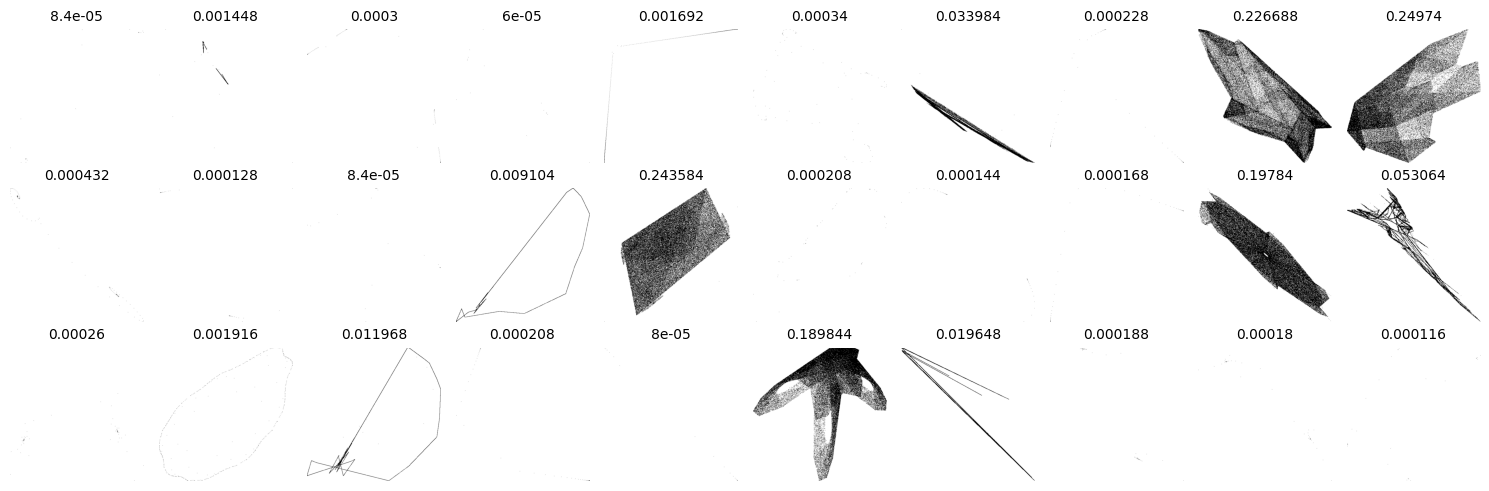

In [117]:
# get the directory to analyze and glob the images
dir_to_analyze = "imgs/cojones/out"
imgs = glob.glob(os.path.join(dir_to_analyze, "*.png"))

# pick some random files from the dirs
random_idxs = np.random.choice(len(imgs), 30, replace=False)
choices = [imgs[i] for i in random_idxs]

# apply the function
rates = [compute_attractor_pixel_rate(choice) for choice in choices]

# show them with the text
show_examples_with_text(choices, rates)

In [118]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import numpy as np

def perform_clustering(data, algorithm='kmeans', n_clusters=3, eps=0.5, min_samples=5):
    """
    Performs clustering using various algorithms.
    
    Args:
        data (np.array): Normalized data matrix (N_samples, N_features).
        algorithm (str): 'kmeans', 'dbscan', or 'hierarchical'.
        n_clusters (int): Used for KMeans and Hierarchical.
        eps (float): The maximum distance between two samples for one to be considered 
                     in the neighborhood of the other. Used for DBSCAN.
        min_samples (int): The number of samples in a neighborhood for a point 
                           to be considered as a core point. Used for DBSCAN.
    
    Returns:
        np.array: Cluster labels.
    """
    if algorithm == 'kmeans':
        # K-Means: Fast, but assumes spherical clusters
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = model.fit_predict(data)
        
    elif algorithm == 'hierarchical':
        # Hierarchical: Good for hierarchy, similar to the Scipy version
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(data)
        
    elif algorithm == 'dbscan':
        # DBSCAN: Finds arbitrary shapes, detects noise (outliers)
        # Note: DBSCAN does NOT use n_clusters. It finds them automatically.
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(data)
        
    else:
        raise ValueError("Unknown algorithm. Choose 'kmeans', 'hierarchical', or 'dbscan'")
        
    return labels

In [119]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def plot_dendrogram(data, title="Hierarchical Dendrogram"):
    """
    Plots the dendrogram to help visually decide the number of clusters.
    """
    # 1. Calculate linkage (Ward's method)
    # This is fast and matches what sklearn AgglomerativeClustering does by default
    Z = linkage(data, method='ward')

    # 2. Plot
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance (Ward)')
    
    # dendrogram returns a dictionary of data used to create the plot
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
        truncate_mode='lastp', # Show only the last p merged clusters
        p=30,                  # to keep the plot readable if you have many points
        show_contracted=True
    )
    plt.show()

In [120]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_k(data, max_k=10, algorithm='kmeans'):
    """
    Calculates Silhouette scores for K-Means OR Hierarchical clustering.
    """
    scores = []
    k_range = range(2, max_k + 1)
    
    print(f"Calculating optimal K using {algorithm}...")
    
    for k in k_range:
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
        elif algorithm == 'hierarchical':
            # Agglomerative Clustering (Ward is standard)
            model = AgglomerativeClustering(n_clusters=k)
            
        labels = model.fit_predict(data)
        
        # Calculate score
        score = silhouette_score(data, labels)
        scores.append(score)
        
    # Find best K
    best_k = k_range[np.argmax(scores)]
    print(f"--> Recommended K: {best_k}")
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, scores, marker='o', color='purple')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Analysis ({algorithm})')
    plt.grid(True)
    plt.show()
    
    return best_k

In [121]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10, Category20, Turbo256

def visualize_clusters_responsive(data_2d, labels, image_paths, title="Cluster Viz"):
    
    # 1. Prepare Labels
    str_labels = [str(x) for x in labels]
    unique_labels = sorted(list(set(str_labels)))
    n_clusters = len(unique_labels)
    
    print(f"Visualizing {n_clusters} unique clusters: {unique_labels}")

    # 2. Smart Palette Selection
    if n_clusters <= 10:
        # High contrast for few clusters
        my_palette = Category10[10] 
    elif n_clusters <= 20:
        # High contrast for medium clusters
        my_palette = Category20[20]
    else:
        # If huge number of clusters, we must sample from the large Turbo palette
        # explicitly to ensure they aren't all the same shade of blue.
        # We pick colors evenly spaced across the spectrum.
        step = len(Turbo256) // n_clusters
        my_palette = [Turbo256[i * step] for i in range(n_clusters)]

    # 3. Create Data Source
    source = ColumnDataSource(data=dict(
        x=data_2d[:, 0],
        y=data_2d[:, 1],
        label=str_labels,
        imgs=image_paths
    ))

    # 4. Create Plot
    p = figure(
        title=title,
        sizing_mode="stretch_both", 
        tools="pan,wheel_zoom,reset,save"
    )

    # 5. Add Circles with Corrected Palette
    p.circle('x', 'y', source=source, size=20, alpha=0.8,
             legend_field='label',
             color=factor_cmap('label', palette=my_palette, factors=unique_labels))

    # 6. Tooltips
    hover = HoverTool(tooltips="""
        <div style="padding: 10px; background-color: white; border-radius: 5px;">
            <div>
                <img
                    src="@imgs" height="120" width="120"
                    style="float: left; margin: 0px 15px 15px 0px; border: 2px solid #ccc;"
                >
            </div>
            <div style="font-family: sans-serif;">
                <span style="font-size: 16px; font-weight: bold; color: #333;">Cluster @label</span>
                <br>
                <span style="font-size: 12px; color: #666;">Rate (x): @x{0.000}</span>
                <br>
                <span style="font-size: 12px; color: #666;">Lyap (y): @y{0.000}</span>
            </div>
        </div>
    """)

    p.add_tools(hover)
    p.legend.click_policy = "hide"
    
    output_file("clustering_responsive.html")
    show(p)

In [122]:
imgs = glob.glob(os.path.join(dir_to_analyze, "*.png"))
rates = [compute_attractor_pixel_rate(img) for img in imgs]
jsons = glob.glob(os.path.join(dir_to_analyze, "*.json"))

lyap = []
for js in jsons:
    with open(js, 'r') as f:
    # Parsing the JSON file into a Python dictionary
        d = json.load(f)
    lyap.append(d["lyapunov"]["normalized_lyapunov"])
    
print(len(imgs), imgs[:5])
print(len(rates), rates[:5])
print(len(lyap), lyap[:5])

200 ['imgs/cojones/out/70_0.png', 'imgs/cojones/out/145_0.png', 'imgs/cojones/out/19_0.png', 'imgs/cojones/out/94_0.png', 'imgs/cojones/out/92_0.png']
200 [np.float64(0.00032), np.float64(0.001364), np.float64(0.007228), np.float64(0.000316), np.float64(0.000196)]
200 [9.363748772512531, 11.152328980681737, 10.869829133892281, 9.944797286057867, 8.192646231555136]


In [123]:
import os
import glob
import json
import numpy as np
from scipy.stats import zscore

# Assume compute_attractor_pixel_rate is defined in your scope
# from your_module import compute_attractor_pixel_rate 

def prepare_data(dir_to_analyze):
    data_points = []
    valid_img_paths = []

    # 1. Get all JSONs (we use these as the 'anchor' files)
    json_files = glob.glob(os.path.join(dir_to_analyze, "*.json"))
    
    print(f"Found {len(json_files)} JSON files. Processing...")

    for json_path in json_files:
        # Construct the expected PNG path based on the JSON filename
        # e.g., "data/image_01.json" -> "data/image_01.png"
        base_name = os.path.splitext(json_path)[0]
        png_path = base_name + ".png"

        # Only process if the pair exists
        if os.path.exists(png_path):
            try:
                # A. Extract Lyapunov
                with open(json_path, 'r') as f:
                    data_dict = json.load(f) # Don't use 'dict' as variable name
                    val_lyap = data_dict["lyapunov"]["normalized_lyapunov"]

                # B. Extract Rate
                val_rate = compute_attractor_pixel_rate(png_path)

                # C. Append to lists
                # Feature vector: [pixel_rate, lyapunov_exponent]
                data_points.append([val_rate, val_lyap])
                valid_img_paths.append(png_path)
                
            except Exception as e:
                print(f"Error processing {base_name}: {e}")
        else:
            print(f"Warning: No matching PNG found for {json_path}")

    # Convert to Numpy Array for Scipy/Clustering
    X = np.array(data_points)
    
    return X, valid_img_paths

In [ ]:
from scipy.stats import zscore
# load, prepare and normalize
X_raw, img_paths = prepare_data("/home/usbt0p/Programs/strange_attractors/imgs/cojones/out")
X_normalized = zscore(X_raw, axis=0)

Calculating optimal K using hierarchical...
--> Recommended K: 3


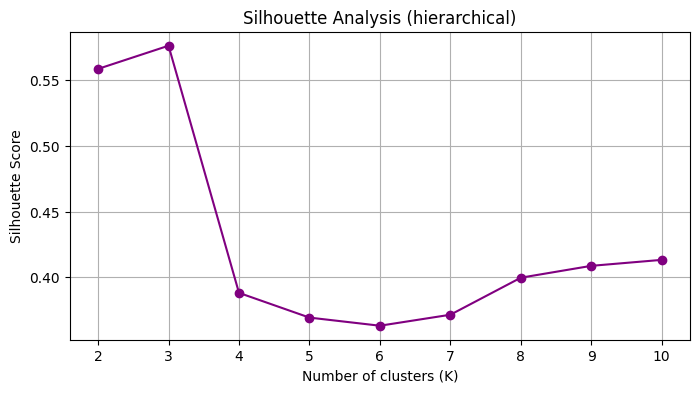

Visualizing 4 unique clusters: ['0', '1', '2', '3']


Gtk-Message: 18:15:56.862: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.


In [131]:
# We use X_normalized for the math, but we can visualize X_raw or X_normalized
algo = "hierarchical"
suggested_k = find_optimal_k(X_normalized, algorithm=algo, max_k=10)
labels = perform_clustering(X_normalized, algorithm=algo, n_clusters=4)

# # simple dim reduction
# # We need 2D for the plot. We use a simple PCA via Scipy SVD
# print("Reducing dimensions for visualization...")
# centered_data = data_high_dim - np.mean(data_high_dim, axis=0)
# U, S, Vt = np.linalg.svd(centered_data)
# data_2d = U[:, :2] * S[:2] 

visualize_clusters_responsive(X_raw, labels, img_paths, title=f"Rate vs Lyapunov ({algo}, k={suggested_k}")

Calculating optimal K using kmeans...
--> Recommended K: 3


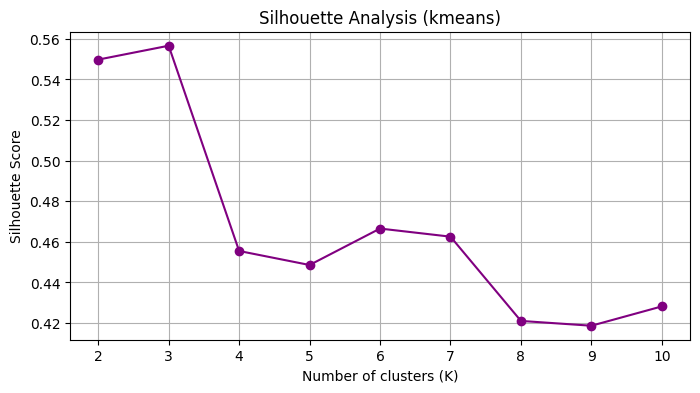

Visualizing 3 unique clusters: ['0', '1', '2']


Gtk-Message: 18:11:00.136: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.


In [ ]:
algo = "hierarchical"
suggested_k = find_optimal_k(X_normalized, algorithm=algo, max_k=10)
labels = perform_clustering(X_normalized, algorithm=algo, n_clusters=suggested_k)

# Option 2: Try DBSCAN (Density based)
# Note: DBSCAN is tricky. You must tune 'eps'. 
# If 'eps' is too small, everything is noise (-1). If too big, everything is one cluster.
# labels = perform_advanced_clustering(X_normalized, algorithm='dbscan', eps=0.5)

visualize_clusters_responsive(X_raw, labels, img_paths, title=f"Responsive Cluster Analysis ({algo}, k={suggested_k})")